# C14-hepatocyte analysis

In [42]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [43]:
%%R
library(ggplot2)

In [44]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [45]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

In [46]:
R = c14.models.liver.R()

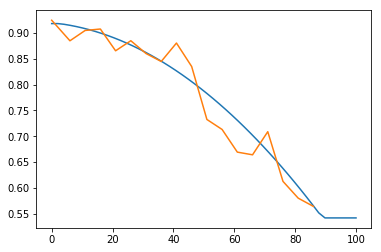

In [47]:
t = np.linspace(0, 100)
ploidy_data = pd.read_excel(c14.models.liver.default_path)
plt.plot(t, R.ploidy(t))
plt.plot(ploidy_data['age_min'], ploidy_data['2C_mean']/100)

In [62]:
parameters = pd.read_hdf('../../../data/julian_fits_200205/richtig_1s_R.pandas').reset_index()

In [63]:
parameters.head()

,time,para,mean,sd,hpd_15.85%,hpd_84.15%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,std,median_std,percentile.1585,median,percentile.8415
0,0,delta2,1.184186,1.694604,0.186631,0.850579,0.041019,0.029010,1706.722780,1706.722780,1797.818884,3509.748033,1.077552,1.694600,1.815558,0.305073,0.532586,1.768237
1,0,delta4,0.071703,0.054460,0.046671,0.087769,0.000959,0.000678,3222.768433,3222.768433,1926.513207,2939.170238,1.074268,0.054460,0.054567,0.049245,0.068287,0.090747
2,0,kappa24,0.001895,0.000912,0.001000,0.002071,0.000020,0.000014,1984.145087,1984.145087,1856.055205,4714.671521,1.078208,0.000912,0.000940,0.001166,0.001667,0.002629
3,0,kappa42,0.013532,0.015995,0.001000,0.014624,0.000346,0.000245,2137.823655,2137.823655,1502.932630,5971.839136,1.093825,0.015995,0.017232,0.001835,0.007120,0.027033
4,0,r2,1.184877,1.694608,0.190045,0.853323,0.041020,0.029011,1706.649140,1706.649140,1794.935401,3499.941908,1.077555,1.694604,1.815579,0.305868,0.533229,1.768491


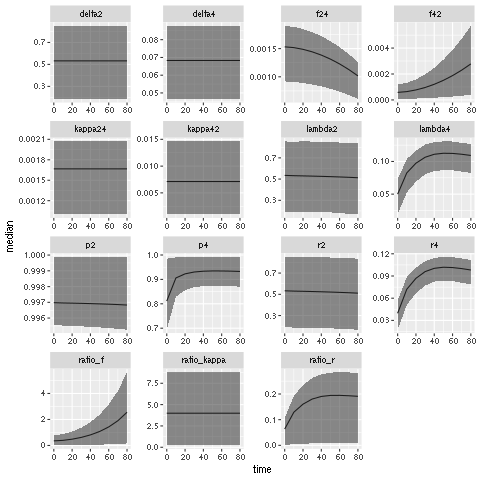

In [64]:
%%R -i parameters 
ggplot(parameters, aes(x=time, y=median, ymin=hpd_15.85., ymax=hpd_84.15.)) + 
    facet_wrap(~para, scale='free') +
    geom_line() +
    geom_ribbon(aes(alpha = 0.1), show.legend=F)

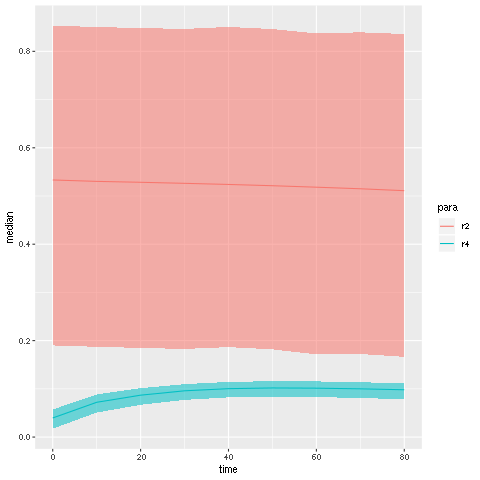

In [56]:
%%R -i parameters
ggplot(parameters[parameters$para %in% c('r2', "r4"),],
       aes(x=time, y=median, ymin=hpd_15.85., ymax=hpd_84.15., fill=para)) + 
    geom_line(aes(color=para)) +
    geom_ribbon(aes(alpha = 0.0001), show.legend=F)

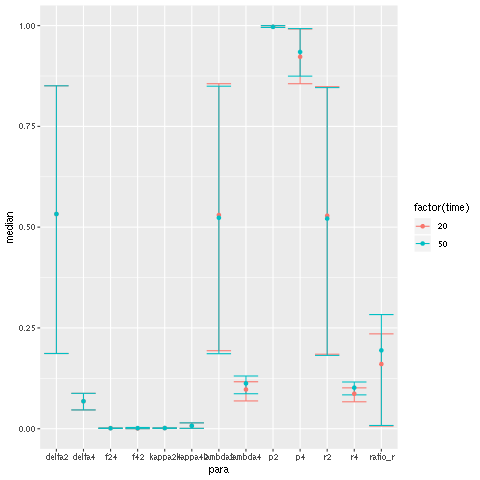

In [58]:
%%R -i parameters
ggplot(parameters[(parameters$time %in% c(20, 50)) & !(parameters$para %in% c('ratio_kappa', 'ratio_f')), ], aes(x=para, y=median, ymin=hpd_15.85., ymax=hpd_84.15., color=factor(time))) + 
    geom_errorbar() + 
    geom_point()